**Pix-2-Pix Model using TensorFlow and Keras**

A port of pix-2-pix model built using TensorFlow's high level `tf.keras` API.

Note: GPU is required to make this model train quickly. Otherwise it could take hours.

Original : https://www.kaggle.com/vikramtiwari/pix-2-pix-model-using-tensorflow-and-keras/notebook

## Installations

In [2]:
requirements = """
keras
git+https://www.github.com/keras-team/keras-contrib.git
matplotlib
numpy
scipy
pillow
#urllib
#skimage
scikit-image
#gzip
#pickle
"""
%store requirements > requirements.txt

Writing 'requirements' (str) to file 'requirements.txt'.


In [3]:
!pip install -r requirements.txt

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-e1d6fp2x
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-e1d6fp2x
  Stored in directory: /tmp/pip-ephem-wheel-cache-lyczwmko/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


## Data Import

In [4]:
# !mkdir datasets
# URL="https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facade.tar.gz"
# TAR_FILE="./datasets/facade.tar.gz"
# TARGET_DIR="./datasets/facade/"
# !wget -N URL -O TAR_FILE
# !mkdir TARGET_DIR
# !tar -zxvf TAR_FILE -C ./datasets/
# !rm TAR_FILE
import tensorflow as tf
import os
_URL = 'https://drive.google.com/uc?export=download&id=1dnLTTT19YROjpjwZIZpJ1fxAd91cGBJv'
path_to_zip = tf.keras.utils.get_file('pix2pix.zip', origin=_URL,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'pix2pix/')

30171136/30168306 [==============================] - 1s 0us/step


In [5]:
PATH

'/root/.keras/datasets/facades/'

## Imports

In [0]:
import os
import datetime
import imageio
import skimage
import scipy # 
# from PIL import Image as Img
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from IPython.display import Image

tf.logging.set_verbosity(tf.logging.ERROR)

# datasetpath = "D:/Yogesh/Projects/Learning/DataScience/Datasets/pix2pix/"
# # datasetpath = "./"

In [0]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(100, 100)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        #         path = glob('../input/%s/%s/%s/*' % (self.dataset_name, self.dataset_name, data_type))
        path = glob(PATH + '%s/*' % (data_type))
        
        batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = self.imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            #  img_A = scipy.misc.imresize(img_A, self.img_res)
            #  img_A = np.array(Img.fromarray(img_A).resize(self.img_res))
            img_A = np.array(skimage.transform.resize(img_A,self.img_res))
            #  img_B = scipy.misc.imresize(img_B, self.img_res)
            #  img_B = np.array(Img.fromarray(img_B).resize(self.img_res))
            img_B = np.array(skimage.transform.resize(img_B,self.img_res))

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
#         path = glob('../input/%s/%s/%s/*' % (self.dataset_name, self.dataset_name, data_type))
        path = glob(PATH + '%s/*' % (data_type))
        self.n_batches = int(len(path) / batch_size)

        for i in range(self.n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                #  img_A = scipy.misc.imresize(img_A, self.img_res)
                #  img_A = np.array(Img.fromarray(img_A).resize(self.img_res))
                img_A = np.array(skimage.transform.resize(img_A,self.img_res))
                #  img_B = scipy.misc.imresize(img_B, self.img_res)
                #  img_B = np.array(Img.fromarray(img_B).resize(self.img_res))
                img_B = np.array(skimage.transform.resize(img_B,self.img_res))

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def imread(self, path):
        return imageio.imread(path).astype(np.float)

In [0]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'facades'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = int(rowpixels/4) # 64
        self.df = int(rowpixels/4) # 64

        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return tf.keras.models.Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return tf.keras.models.Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('./images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [0]:
gan = Pix2Pix()
# gan.train(epochs=200, batch_size=1, sample_interval=200)

In [10]:
gan.train(epochs=1, batch_size=1, sample_interval=200)
# training logs are hidden in published notebook

[Epoch 0/1] [Batch 0/400] [D loss: 7.366525, acc:  47%] [G loss: 68.635727] time: 0:00:23.322587
[Epoch 0/1] [Batch 1/400] [D loss: 5.214497, acc:  44%] [G loss: 86.222618] time: 0:00:32.990237
[Epoch 0/1] [Batch 2/400] [D loss: 6.213814, acc:  55%] [G loss: 63.264542] time: 0:00:39.683055
[Epoch 0/1] [Batch 3/400] [D loss: 6.244776, acc:  49%] [G loss: 60.785915] time: 0:00:46.496686
[Epoch 0/1] [Batch 4/400] [D loss: 3.331285, acc:  49%] [G loss: 55.958744] time: 0:00:53.250952
[Epoch 0/1] [Batch 5/400] [D loss: 2.346199, acc:  52%] [G loss: 47.432812] time: 0:01:00.053317
[Epoch 0/1] [Batch 6/400] [D loss: 2.604008, acc:  50%] [G loss: 59.526821] time: 0:01:06.784745
[Epoch 0/1] [Batch 7/400] [D loss: 1.926466, acc:  46%] [G loss: 43.438496] time: 0:01:13.385060
[Epoch 0/1] [Batch 8/400] [D loss: 1.771073, acc:  54%] [G loss: 50.090115] time: 0:01:20.134048
[Epoch 0/1] [Batch 9/400] [D loss: 1.539141, acc:  51%] [G loss: 54.364681] time: 0:01:26.594489
[Epoch 0/1] [Batch 10/400] [D 

Let's see how our model performed over time.

In [0]:
from PIL import Image as Img

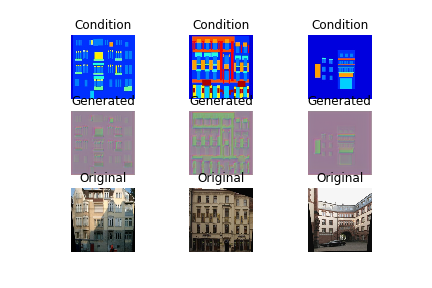

In [20]:
Image('./images/facades/0_0.png')

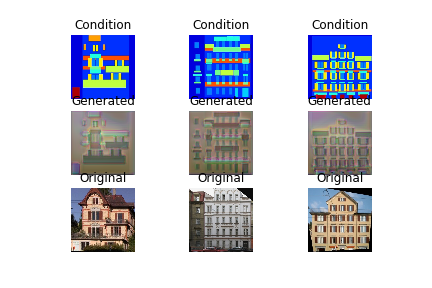

In [12]:
Img('./images/facades/0_200.png')

In [22]:
Image('./images/facades/5_200.png')

In [14]:
Img('./images/facades/9_200.png')

This is the result of 10 iterations. You can train the model for more than 10 iterations and it will produce better results. Also, try this model with different datasets.